In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import keras
import numpy as np
from keras.datasets import mnist
from keras import models
from keras import layers
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [3]:
# MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Generate corrupted MNIST images by adding noise with normal dist
# centered at 0.5 and std=0.5
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noisy = x_test + noise

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
# Network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
latent_dim = 16
# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

In [5]:
# Build the Autoencoder Model
# First build the Encoder Model
inputs = layers.Input(shape=input_shape, name='encoder_input')
x = inputs
# Stack of Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use MaxPooling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters:
    x = layers.Conv2D(filters=filters,
                      kernel_size=kernel_size,
                      strides=2,
                      activation='relu',
                      padding='same')(x)

# Shape info needed to build Decoder Model
shape = K.int_shape(x)

# Generate the latent vector
x = layers.Flatten()(x)
latent = layers.Dense(latent_dim, name='latent_vector')(x)

# Instantiate Encoder Model
encoder = models.Model(inputs, latent, name='encoder')
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Build the Decoder Model
latent_inputs = layers.Input(shape=(latent_dim,), name='decoder_input')
x = layers.Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = layers.Reshape((shape[1], shape[2], shape[3]))(x)

# Stack of Transposed Conv2D blocks
# Notes:
# 1) Use Batch Normalization before ReLU on deep networks
# 2) Use UpSampling2D as alternative to strides>1
# - faster but not as good as strides>1
for filters in layer_filters[::-1]:
    x = layers.Conv2DTranspose(filters=filters,
                               kernel_size=kernel_size,
                               strides=2,
                               activation='relu',
                               padding='same')(x)

x = layers.Conv2DTranspose(filters=1,
                           kernel_size=kernel_size,
                           padding='same')(x)

outputs = layers.Activation('sigmoid', name='decoder_output')(x)

# Instantiate Decoder Model
decoder = models.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         289       
_________________________________________________________________
decoder_output (Activation)  (None, 28, 28, 1)         0         
Total para

In [7]:
# Autoencoder = Encoder + Decoder
# Instantiate Autoencoder Model
autoencoder = models.Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()
autoencoder.compile(loss='mse', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train the autoencoder
autoencoder.fit(x_train_noisy,
                x_train,
                validation_data=(x_test_noisy, x_test),
                epochs=30,
                batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 7s 109us/step - loss: 0.0634 - val_loss: 0.0338
Epoch 2/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.0267 - val_loss: 0.0222
Epoch 3/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.0210 - val_loss: 0.0199
Epoch 4/30
60000/60000 [==============================] - 4s 71us/step - loss: 0.0191 - val_loss: 0.0184
Epoch 5/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.0180 - val_loss: 0.0177
Epoch 6/30
60000/60000 [==============================] - 4s 73us/step - loss: 0.0174 - val_loss: 0.0173
Epoch 7/30
60000/60000 [==============================] - 4s 72us/step - loss: 0.0170 - val_loss: 0.0169
Epoch 8/30
60000/60000 [==============================] - 4s 71us/step - loss: 0.0166 - val_loss: 0.0166
Epoch 9/30
60000/60000 [==============================] - 4s 

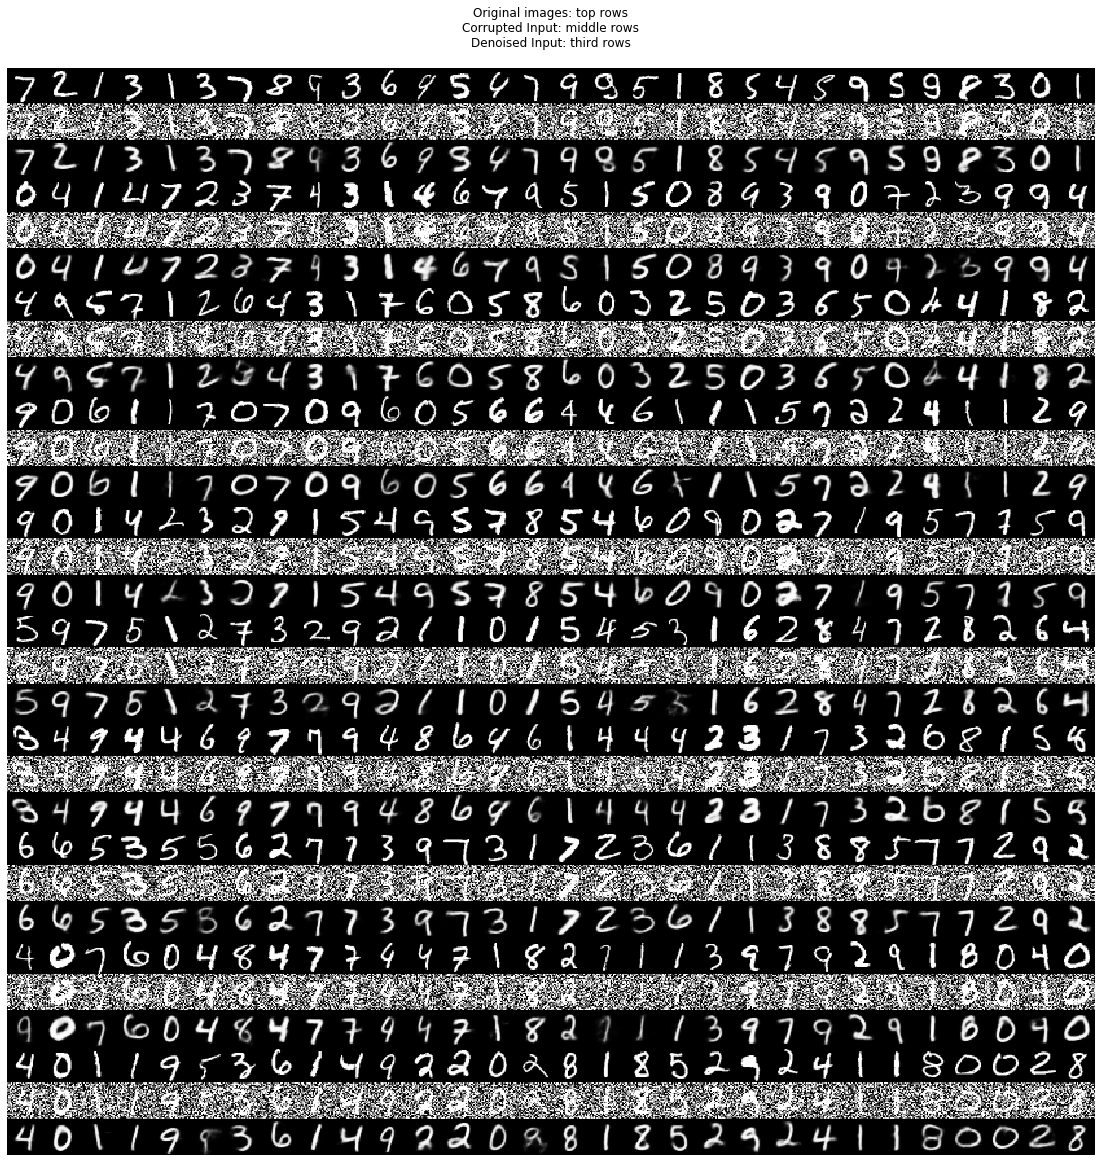

In [9]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 8 corrupted and denoised images
rows, cols = 10, 30
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.title('Original images: top rows\n'
          'Corrupted Input: middle rows\n'
          'Denoised Input: third rows\n')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()